# Comparison of 5 regridding algorithms

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe

Those algorithms are available:

In [2]:
method_list = ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']

- Bilinear and conservative should be the most commonly used methods. They are both monotonic (i.e. will not create new maximum/minimum). 
- Nearest neighbour methods, either source to destination (s2d) or destination to source (d2s), could be useful in special cases. Keep in mind that d2s is highly non-monotonic.
- Patch is ESMF's unique methods, leading to highly smooth results but quite slow.

Detailed explanations are available on [ESMPy documentation](http://www.earthsystemmodeling.org/esmf_releases/last_built/esmpy_doc/html/api.html#regridding).

## Preparation

In [3]:
ds_in = xe.util.grid_global(20, 15)  # input grid
ds_fine = xe.util.grid_global(4, 4)  # for down-sampling
ds_coarse = xe.util.grid_global(30, 20)  # for up-sampling

Make a wave field that is widely used in regridding benchmarks.

In [4]:
ds_in['data'] = xe.data.wave_smooth(ds_in['lon'], ds_in['lat'])
ds_in

<xarray.Dataset>
Dimensions:  (x: 18, x_b: 19, y: 12, y_b: 13)
Coordinates:
    lon      (y, x) float64 -170.0 -150.0 -130.0 -110.0 -90.0 -70.0 -50.0 ...
    lat      (y, x) float64 -82.5 -82.5 -82.5 -82.5 -82.5 -82.5 -82.5 -82.5 ...
    lon_b    (y_b, x_b) int64 -180 -160 -140 -120 -100 -80 -60 -40 -20 0 20 ...
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data     (y, x) float64 2.016 2.009 1.997 1.987 1.983 1.987 1.997 2.009 ...

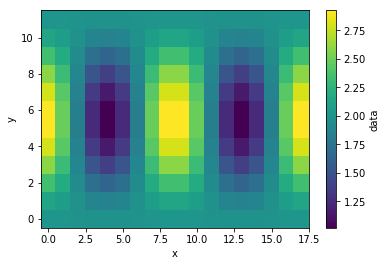

In [5]:
ds_in['data'].plot()

In [6]:
def regrid(ds_in, ds_fine, dr_in, method):
    """Convenience function one-time regridding"""
    regridder = xe.Regridder(ds_in, ds_fine, method, periodic=True)
    dr_out = regridder(dr_in)
    regridder.clean_weight_file()
    return dr_out

When dealing with global grids, we need to set `periodic=True`, otherwise data along the meridian line will be missing.

## Down-sampling

In [7]:
for method in method_list:
    %time ds_fine[method] = regrid(ds_in, ds_fine, ds_in['data'], method)
    print('')

Create weight file: bilinear_12x18_45x90_peri.nc
Remove file bilinear_12x18_45x90_peri.nc
CPU times: user 169 ms, sys: 29 ms, total: 198 ms
Wall time: 255 ms

Create weight file: conservative_12x18_45x90.nc
Remove file conservative_12x18_45x90.nc
CPU times: user 146 ms, sys: 3.88 ms, total: 150 ms
Wall time: 153 ms

Create weight file: nearest_s2d_12x18_45x90_peri.nc
Remove file nearest_s2d_12x18_45x90_peri.nc
CPU times: user 54.4 ms, sys: 1.93 ms, total: 56.3 ms
Wall time: 57.1 ms

Create weight file: nearest_d2s_12x18_45x90_peri.nc
Remove file nearest_d2s_12x18_45x90_peri.nc
CPU times: user 19.8 ms, sys: 1.19 ms, total: 21 ms
Wall time: 21.3 ms

Create weight file: patch_12x18_45x90_peri.nc
Remove file patch_12x18_45x90_peri.nc
CPU times: user 712 ms, sys: 26 ms, total: 738 ms
Wall time: 745 ms



Nearest neighbour algorithms are very fast while the patch method is quite slow.

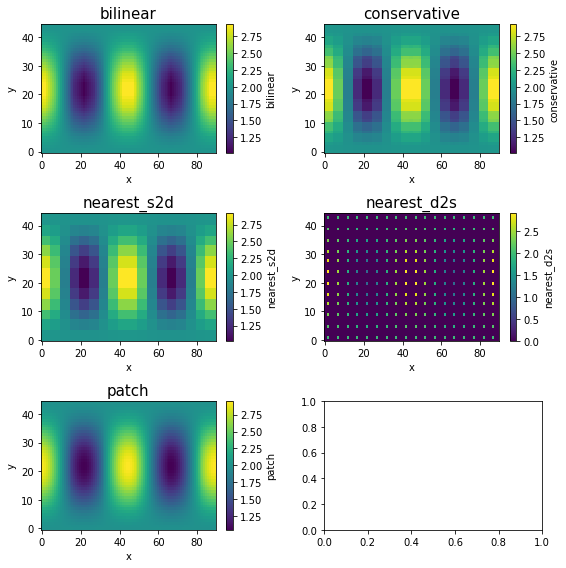

In [8]:
fig, axes = plt.subplots(3, 2, figsize=[8, 8])

for i, method in enumerate(method_list):
    ax = axes.flatten()[i]
    ds_fine[method].plot.pcolormesh(ax=ax)
    ax.set_title(method, fontsize=15)
    
plt.tight_layout()

When regridding from low-resolution to high-resolution (down-sampling), `bilinear` and `patch` will produce smooth results, while `conservative` and `nearest_s2d` will preserve the original coarse grid structure (although the data is now define on a finer grid.). 

`nearest_d2s` is quite different from others: One source point is mapped to **only one destination point**. Because we have far less source points (on a low-resolution grid) than destination points (on a high-resolution grid), most destination points cannot receive any data so they just have zero values. Only the destination points that are closest to source points can receive data.

## Up-sampling

In [9]:
for method in method_list:
    ds_coarse[method] = regrid(ds_in, ds_coarse, ds_in['data'], method)

Create weight file: bilinear_12x18_9x12_peri.nc
Remove file bilinear_12x18_9x12_peri.nc
Create weight file: conservative_12x18_9x12.nc
Remove file conservative_12x18_9x12.nc
Create weight file: nearest_s2d_12x18_9x12_peri.nc
Remove file nearest_s2d_12x18_9x12_peri.nc
Create weight file: nearest_d2s_12x18_9x12_peri.nc
Remove file nearest_d2s_12x18_9x12_peri.nc
Create weight file: patch_12x18_9x12_peri.nc
Remove file patch_12x18_9x12_peri.nc


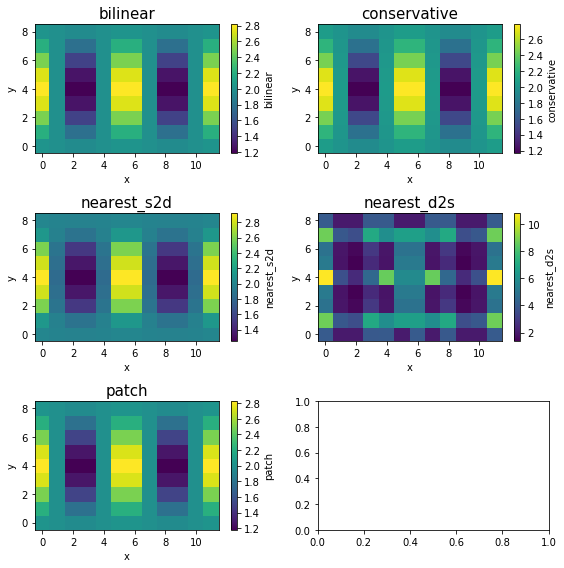

In [10]:
fig, axes = plt.subplots(3, 2, figsize=[8, 8])

for i, method in enumerate(method_list):
    ax = axes.flatten()[i]
    ds_coarse[method].plot.pcolormesh(ax=ax)
    ax.set_title(method, fontsize=15)
    
plt.tight_layout()

When regridding from high-resolution to low-resolution (up-sampling), all methods except `nearest_d2s` produce similar results here. But that's largely because the input data is smooth. For real-world data, it is generally recommended to use `conservative` for up-samplig, because it takes average over small source grid boxes, while `bilinear` and `nearest_s2d` effectively throw away most of source grid boxes.

`nearest_d2s` is again different: **Every** source point will **always** be mapped to a destination point. Because we have far more source points (on a high-resolution grid) than destination points (on a low-resolution grid), a single destination point will receive data from multiple source points, which can accumulate to a large value (notice the colorbar range).